# AIS Data Exploration
**Maintainer**: Team NYC <br>
**Date**: 03/21/2020

Below is some sample code that ingests AIS data and does a proof of concepts of potential visualizations that could exist in the Team NYC dashboard. 

### Potentially Useful Links

* [Heterogeneous Integrated Dataset for Maritime Intelligence, Surveillance, and Reconnaissanc](https://zenodo.org/record/1167595#.XnacYKhKhhH)
* [IMO Vessel Types Ref Table](https://github.com/warrantgroup/IMO-Vessel-Codes/blob/master/data/imo-vessel-codes.csv)
* [CO2 Emission Calculator](https://github.com/warrantgroup/IMO-Vessel-Codes/blob/master/data/imo-vessel-codes.csv)
* [AIS Shiptype Numbers](https://help.marinetraffic.com/hc/en-us/articles/205579997-What-is-the-significance-of-the-AIS-Shiptype-number-)

### Dataset Summary

* AIS Data - Contains details on how 
* AIS Status, Codes, and Types - Ref table for ship types, nav status, etc. 

### Approach/Thoughts

We have a nice reference table that allows us to label each type of ship available the AIS data set. I propose the following steps to tackle this problem:

1. Classify all unique vessels by the type
2. Assign a CO2 emission rate to all unique vessels (Tonnes CO-emissions = 1 kg CO2 per mile travelled)
3. Calculate total distance travelled by each unique vessel.
4. Calculate total CO2 emission from start to end of trip.
5. Visualize

In [1]:
import pandas as pd
import numpy as np

In [8]:
shiptype_ref_df = pd.read_csv("./datasets/ais_ref/Ship Types List.csv")
shiptype_ref_df.head()

,id_shiptype,shiptype_min,shiptype_max,type_name,ais_type_summary
0,1,10,19,Reserved,Unspecified
1,2,20,28,Wing In Grnd,Wing in Grnd
2,3,29,29,SAR Aircraft,Search and Rescue
3,4,30,30,Fishing,Fishing
4,5,31,31,Tug,Tug


In [6]:
shiptype_detailed_ref_df = pd.read_csv("./datasets/ais_ref/Ship Types Detailed List.csv")
shiptype_detailed_ref_df.head()

,id_detailedtype,detailed_type,id_shiptype
0,1,Wing In Ground Effect Vessel,2
1,2,Trawler,4
2,3,Fishery Protection/Research,4
3,4,Fish Carrier,4
4,5,Fish Factory,4


In [9]:
"""
Use below details as a way to classify ships and estimate CO2 emissions. 
We can start naive and improve as we find more information about ship types
"""

def ship_classifier(shiptype):
    """
    Given the ship type, classifies it according to below map.
    """
    shiptype_map = {
        "0": "Other",
        "1": "Reserved",
        "2": "Wing in Ground",
        "3": "Special Category",
        "4": "High-Speed Craft",
        "5": "Special Category",
        "6": "Passenger",
        "7": "Cargo",
        "8": "Tanker",
        "9": "Other"
    }
    return shiptype_map[shiptype[0]]

def calculate_co2(classified_shiptype):
    """
    Given the shiptype, estimate the CO2 kg emissions per mile travelled
    """
    
    co2_map = {
        "Tanker": 1000,
        "Cargo": 500,
        "Passenger": 250
    }
    
    if classified_shiptype in co2_map:
        return co2_map[classified_shiptype]
    return 100

### Unit tests
test_shipcode = "82" 
classified_ship = ship_classifier(test_shipcode)
print(f"{classified_ship} emits CO2:", calculate_co2(classified_ship))

Tanker emits CO2: 1000


In [11]:
# Load and show the data
df = pd.read_csv("./datasets/ais_data/nari_static.csv")
df.head()

C:\Users\Joffrey Baratheon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,sourcemmsi,imonumber,callsign,shipname,shiptype,tobow,tostern,tostarboard,toport,eta,draught,destination,mothershipmmsi,t
0,304091000,9509255.0,V2GU5,HC JETTE-MARIT,70.0,130.0,30.0,18.0,6.0,04-09 20:00,10.1,BREST,NaN,1443650423
1,228037600,0.0,FIHX,AEROUANT BREIZH,30.0,6.0,9.0,5.0,2.0,00-00 24:60,0.0,,NaN,1443650457
2,228064900,8304816.0,FITO,VN SAPEUR,51.0,21.0,54.0,10.0,6.0,29-09 12:00,5.9,RADE DE BREST,NaN,1443650471
3,227705102,262144.0,FGD5860,BINDY,60.0,9.0,26.0,5.0,4.0,00-00 24:60,0.0,,NaN,1443650474
4,227415000,0.0,FHAF,F/V JEREMI SIMON,90.0,11.0,9.0,3.0,3.0,00-00 24:60,0.0,,NaN,1443650479


In [12]:
df['shiptype'] = df['shiptype'].fillna(0)
df['ship_class'] = df['shiptype'].apply(lambda x: ship_classifier(str(int(x))))
df['co2_emitted'] = df['ship_class'].apply(lambda x: calculate_co2(x))
df.head()

,sourcemmsi,imonumber,callsign,shipname,shiptype,tobow,tostern,tostarboard,toport,eta,draught,destination,mothershipmmsi,t,ship_class,co2_emitted
0,304091000,9509255.0,V2GU5,HC JETTE-MARIT,70.0,130.0,30.0,18.0,6.0,04-09 20:00,10.1,BREST,NaN,1443650423,Cargo,500
1,228037600,0.0,FIHX,AEROUANT BREIZH,30.0,6.0,9.0,5.0,2.0,00-00 24:60,0.0,,NaN,1443650457,Special Category,100
2,228064900,8304816.0,FITO,VN SAPEUR,51.0,21.0,54.0,10.0,6.0,29-09 12:00,5.9,RADE DE BREST,NaN,1443650471,Special Category,100
3,227705102,262144.0,FGD5860,BINDY,60.0,9.0,26.0,5.0,4.0,00-00 24:60,0.0,,NaN,1443650474,Passenger,250
4,227415000,0.0,FHAF,F/V JEREMI SIMON,90.0,11.0,9.0,3.0,3.0,00-00 24:60,0.0,,NaN,1443650479,Other,100


,count
ship_class,
Cargo,2757
Tanker,1014
Special Category,619
Other,386
Passenger,61
Wing in Ground,3
High-Speed Craft,2


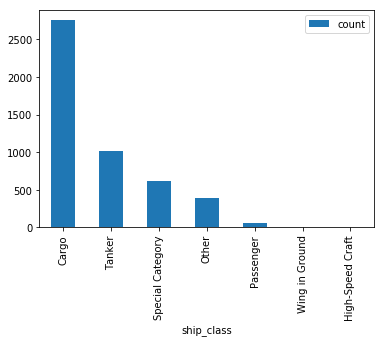

In [14]:
"""
Frequency of all ship types in the given data set
"""

shipclass_agg_df = df.drop_duplicates(subset=['sourcemmsi']).groupby(['ship_class']).agg({"ship_class":"count"})
shipclass_agg_df.columns = ['count']
shipclass_agg_df = shipclass_agg_df.sort_values(by=['count'], ascending=False)
display(shipclass_agg_df)

shipclass_agg_df[['count']].plot.bar()

,co2_emitted
ship_class,
Cargo,93147500
Tanker,61322000
Special Category,51268700
Passenger,45459250
Other,13634400
High-Speed Craft,12200
Wing in Ground,1000


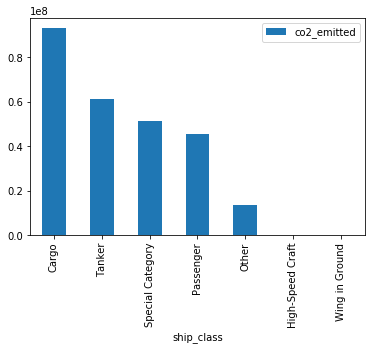

In [16]:
"""
Estimated CO2 emission by ship_class
"""

shipclass_agg_df = df.groupby(['ship_class']).agg({"co2_emitted":"sum"})
shipclass_agg_df.columns = ['co2_emitted']
shipclass_agg_df = shipclass_agg_df.sort_values(by=['co2_emitted'], ascending=False)
display(shipclass_agg_df)

shipclass_agg_df[['co2_emitted']].plot.bar()